### Config

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy.stats import levene, friedmanchisquare, wilcoxon
import seaborn as sns

## Get Actuals

In [80]:
year_df = pd.read_parquet("/Users/tomaltenborg/Documents/Master/Master thesis/Notebooks/M3 Data/M3_yearly_processed.parquet")
quart_df = pd.read_parquet("/Users/tomaltenborg/Documents/Master/Master thesis/Notebooks/M3 Data/M3_quarter_processed.parquet")
month_df = pd.read_parquet("/Users/tomaltenborg/Documents/Master/Master thesis/Notebooks/M3 Data/M3_month_processed.parquet")


def get_actuals (df):
    # Sort the dataframe by Series and Date
    df_sorted = df.sort_values(by=['Series', 'Date'])
    
    # Define a function that gets the last `n` entries for each group
    def last_n_entries(group):
        # `NF` is assumed to be the same for all rows in the group, so we take the first one
        n = group['NF'].iloc[0]
        return group.tail(n)
    
    # Apply the function to each group and concatenate the results
    actuals_df = df_sorted.groupby('Series').apply(last_n_entries).reset_index(drop=True)
    
    return actuals_df

actuals_year_df = get_actuals(year_df)
actuals_quart_df = get_actuals(quart_df)
actuals_month_df = get_actuals(month_df)

actuals_df = pd.concat([actuals_year_df, 
                        actuals_quart_df,
                        actuals_month_df],
                        ignore_index=True)



## Merge

In [81]:
forecasts_df = pd.read_parquet("/Users/tomaltenborg/Documents/Master/Master thesis/Notebooks/Analysis/complete_forecast_data.parquet")

results_df = pd.merge(forecasts_df, actuals_df[['Series', 'Date', 'Value', 'Category', 'NF']], how='left', on=['Series', 'Date'])
results_df['Category'] = results_df['Category'].str.strip()

results_df.rename(columns={'Value': 'Actual'}, inplace=True)
results_df.drop(['SINGLE'], axis=1, inplace=True)

display(results_df)

,Series,Date,TimeGPT,Chronos,Moirai,ForecastPeriod,ARARMA,Auto-ANN,AutoBox1,AutoBox2,...,PP-Autocast,RBF,ROBUST-Trend,SMARTFCS,THETA,THETAsm,WINTER,Actual,Category,NF
0,1,1989-01-01,5121.754395,5471.703660,5075.040039,1,5553.26,5453.28,5442.92,4930.25,...,5475.80,5550.22,5204.32,5259.00,5414.60,5163.08,5406.43,5379.75,MICRO,6
1,1,1990-01-01,4974.531738,5847.765768,5983.503906,2,6246.45,6003.49,5969.23,5479.36,...,6014.62,6152.23,5471.66,5675.00,5934.47,5390.88,5875.96,6158.68,MICRO,6
2,1,1991-01-01,4750.660156,6195.623217,5960.694336,3,7026.18,6587.93,6495.55,5472.61,...,6553.43,6648.95,5738.99,6091.00,6331.96,5155.17,6345.48,6876.58,MICRO,6
3,1,1992-01-01,4366.261719,6195.623217,6046.625977,4,7903.23,7206.76,7021.87,6021.72,...,7092.24,6965.22,6006.32,6507.00,6822.35,5147.46,6815.00,7851.91,MICRO,6
4,1,1993-01-01,3914.425781,5866.568873,7204.881348,5,8889.77,7860.01,7548.18,6014.98,...,7631.05,7038.06,6273.66,6923.00,7140.76,5152.92,7284.53,8407.84,MICRO,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35617,2829,1988-07-01,1437.689209,1259.141011,1307.136963,14,1335.28,1139.87,1254.13,1204.10,...,1384.45,1371.58,1223.93,1170.98,1226.58,1452.61,1193.75,1282.50,OTHER,18
35618,2829,1988-08-01,1442.109741,1243.785633,1468.140381,15,1316.26,1116.26,1234.02,1182.42,...,1380.21,1355.06,1203.67,1147.83,1207.17,1451.93,1171.28,1261.30,OTHER,18
35619,2829,1988-09-01,1439.912842,1243.785633,1361.496338,16,1307.62,1091.50,1213.86,1160.74,...,1376.36,1345.82,1183.41,1124.68,1187.85,1448.36,1148.82,1263.40,OTHER,18
35620,2829,1988-10-01,1437.093018,1243.785633,1473.072998,17,1293.64,1066.18,1193.64,1139.06,...,1372.85,1336.08,1163.14,1101.53,1168.63,1458.19,1126.35,1257.10,OTHER,18


## Calculate Metrics

In [82]:
categories_dict = {
    'NAIVE2': 'Naive/Simple',
    'SINGLE': 'Naive/Simple',
    'HOLT': 'Explicit Trend Models',
    'ROBUST-Trend': 'Explicit Trend Models',
    'WINTER': 'Explicit Trend Models',
    'DAMPEN': 'Explicit Trend Models',
    'PP-Autocast': 'Explicit Trend Models',
    'THETAsm': 'Explicit Trend Models',
    'COMB S-H-D': 'Explicit Trend Models',
    'THETA': 'Decomposition',
    'B-J auto': 'ARIMA/ARARMA Models',
    'AutoBox1': 'ARIMA/ARARMA Models',
    'AutoBox2': 'ARIMA/ARARMA Models',
    'AutoBox3': 'ARIMA/ARARMA Models',
    'AAM1': 'ARIMA/ARARMA Models',
    'AAM2': 'ARIMA/ARARMA Models',
    'ARARMA': 'ARIMA/ARARMA Models',
    'ForecastPro': 'Expert Systems',
    'SMARTFCS': 'Expert Systems',
    'RBF': 'Expert Systems',
    'Flors-Pearc1': 'Expert Systems',
    'Flors-Pearc2': 'Expert Systems',
    'ForcX': 'Expert Systems',
    'Auto-ANN': 'Neural Networks',
    'TimeGPT': 'Foundation Models',
    'Chronos': 'Foundation Models',
    'Moirai': 'Foundation Models'
}

In [83]:
forecast_cols = [col for col in results_df.columns if col not in ['Series', 'Date', 'Naive2', 'Actual', 'ForecastPeriod', 'NF', 'Category']]

def calculate_mase_per_series(df, actual_col, forecast_cols, benchmark_col):
    results = {}

    # Calculate the MAE of the Naive2 benchmark per Series
    df['AbsErrorBenchmark'] = abs(df[actual_col] - df[benchmark_col])
    benchmark_mae = df.groupby('Series')['AbsErrorBenchmark'].mean()

    for series in df['Series'].unique():
        series_df = df[df['Series'] == series].copy()
        series_mase = {}
        for forecast_col in forecast_cols:
            # Calculate the MAE for the forecast method
            series_df['AbsErrorForecast'] = abs(series_df[actual_col] - series_df[forecast_col])
            forecast_mae = series_df['AbsErrorForecast'].mean()
            # Calculate MASE
            series_mase[forecast_col] = forecast_mae / benchmark_mae[series]
        results[series] = series_mase
    
    # Cleanup the temporary columns
    df.drop('AbsErrorBenchmark', axis=1, inplace=True)
    
    return results

mase_results = calculate_mase_per_series(results_df, 'Actual', forecast_cols, 'NAIVE2')
mase_df = pd.DataFrame.from_dict(mase_results, orient='index')

median_mase = mase_df.median().sort_values()

median_mase_df = pd.DataFrame(median_mase, columns=['MedianMASE'])

median_mase_df = median_mase_df.reset_index()
median_mase_df.columns = ['Method', 'MedianMASE']

median_mase_df['Category'] = median_mase_df['Method'].map(categories_dict)

In [84]:
color_map = {
    'Foundation Models': '#17a2b8',  # Vivid Turquoise
    'Naive/Simple': '#c0c0c0',       # Soft Gray
    'ARIMA/ARARMA Models': '#aec6cf', # Gentle Blue
    'Explicit Trend Models': '#7393B3', # Dusty Blue
    'Decomposition': '#93e9be',        # Seafoam Green
    'Expert Systems': '#87cefa',       # Light Sky Blue
    'Neural Networks': '#e6e6fa',      # Pale Lavender
}

category_colors = median_mase_df['Category'].map(color_map)

# Plot Median MASE Scores

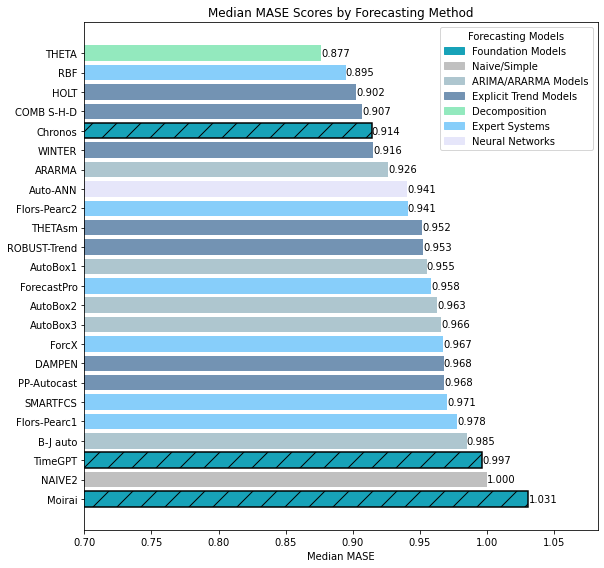

In [85]:
category_colors = median_mase_df['Category'].map(color_map)

plt.figure(figsize=(10, 8))
bars = plt.barh(median_mase_df['Method'], median_mase_df['MedianMASE'], color=category_colors)

transformer_bars = [bar for bar, method in zip(bars, median_mase_df['Method']) if median_mase_df.loc[median_mase_df['Method'] == method, 'Category'].values[0] == 'Foundation Models']
for bar in transformer_bars:
    bar.set_edgecolor('black')  # Adding a black border to the bar
    bar.set_linewidth(1.5)  # Making the border thicker
    bar.set_hatch('/')  # Adding a hatch pattern

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.3f}', va='center', ha='left')

plt.xlabel('Median MASE')
plt.title('Median MASE Scores by Forecasting Method')
plt.gca().invert_yaxis()  # Invert y-axis to have the best method at the top
plt.legend(
    [plt.Rectangle((0,0),1,1, color=color_map[category]) for category in color_map],
    color_map.keys(),
    title="Forecasting Models",
    loc='best'  
)

plt.xlim(left=0.7)
plt.tight_layout(rect=[0,0,0.85,1])  
plt.show()

# Plot Distribution of MASE Score for Selection of Models

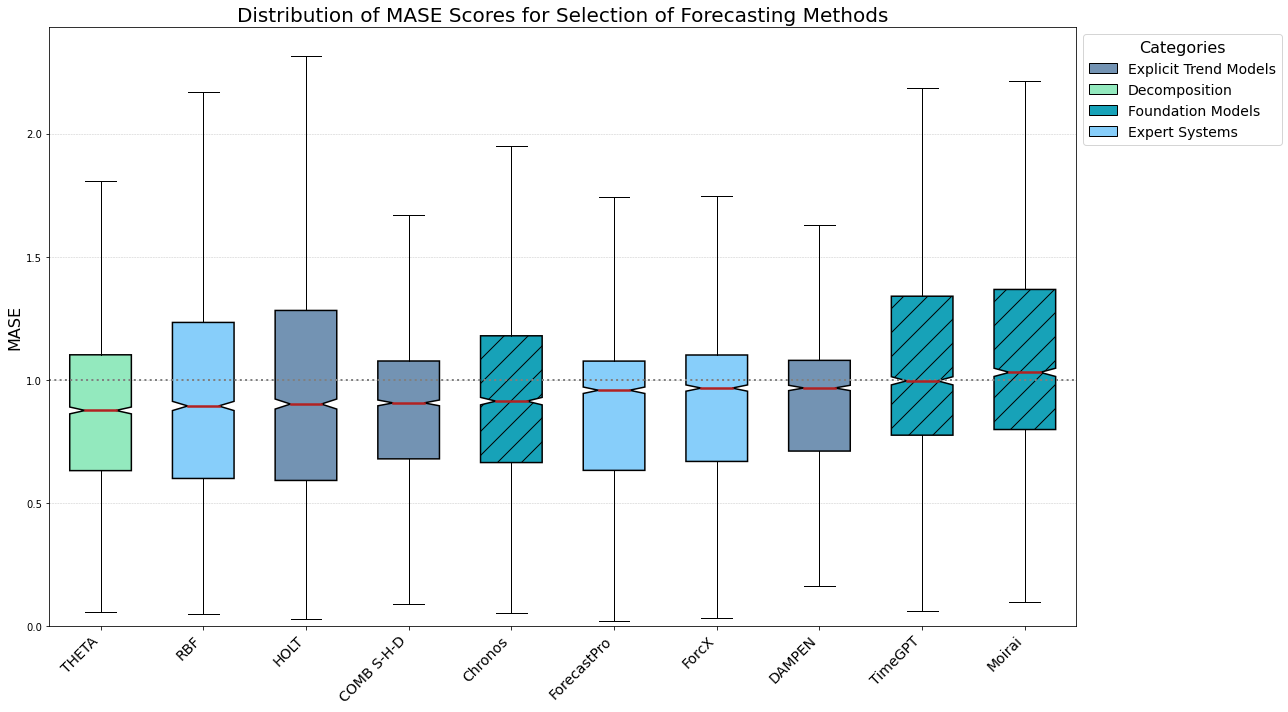

In [86]:
df = mase_df

var_methods = [
    'THETA',
    'ForecastPro',
    'HOLT',
    'ForcX',
    'COMB S-H-D',
    'DAMPEN',
    'RBF',
    'TimeGPT',
    'Chronos',
    'Moirai'
]

df_filtered = df[var_methods]

medians = df_filtered.median().sort_values()

def boxprops(method):
    category = categories_dict[method]
    return {'linestyle': '-', 'linewidth': 2.5, 'color': color_map[category]}

# Define median line properties
medianprops = {'linestyle': '-', 'linewidth': 2.5, 'color': 'firebrick'}

plt.figure(figsize=(18, 10))

used_categories = set()

# Plot each method in the sorted order
for i, method in enumerate(medians.index):
    box = plt.boxplot(df_filtered[method], positions=[i], labels=[method], showfliers=False,
                      boxprops=boxprops(method), medianprops=medianprops, widths=0.6, patch_artist=True, notch=True)
    # Set fill color and highlight if necessary
    category = categories_dict[method]
    used_categories.add(category)  # Add category to set of used categories
    for patch in box['boxes']:
        patch.set_facecolor(color_map[category])
        if category == 'Foundation Models':
            patch.set_edgecolor('black')  # Adding a black border to the box
            patch.set_linewidth(1.5)  # Making the border thicker
            patch.set_hatch('/')  # Adding a hatch pattern
        else:
            patch.set_edgecolor('black')
            patch.set_linewidth(1.5)

plt.xticks(rotation=45, ha='right', fontsize=14)  # Increase font size of x-axis labels

# Set grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y', alpha=0.7)

# Set limits for y-axis
plt.ylim(bottom=0)

# Set labels and title
plt.ylabel('MASE', fontsize=16)  # Increase font size of y-axis label
plt.title('Distribution of MASE Scores for Selection of Forecasting Methods', fontsize=20)  # Increase font size of title

# Benchmark line
plt.axhline(y=1, color='grey', linestyle='dotted', linewidth=2, label='Benchmark')

# Create legend from the color map only for used categories
legend_elements = [Patch(facecolor=color_map[cat], edgecolor='black', label=cat) for cat in used_categories]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), title="Categories", fontsize=14, title_fontsize=16)  # Increase font sizes in the legend

# Layout adjustment and show plot
plt.tight_layout()
plt.show()


# Create Table for MASE Scores

In [87]:
categories_dict = {
    'NAIVE2': 'Naive/Simple',
    'SINGLE': 'Naive/Simple',
    'HOLT': 'Explicit Trend Models',
    'ROBUST-Trend': 'Explicit Trend Models',
    'WINTER': 'Explicit Trend Models',
    'DAMPEN': 'Explicit Trend Models',
    'PP-Autocast': 'Explicit Trend Models',
    'THETAsm': 'Explicit Trend Models',
    'COMB S-H-D': 'Explicit Trend Models',
    'THETA': 'Decomposition',
    'B-J auto': 'ARIMA/ARARMA Models',
    'AutoBox1': 'ARIMA/ARARMA Models',
    'AutoBox2': 'ARIMA/ARARMA Models',
    'AutoBox3': 'ARIMA/ARARMA Models',
    'AAM 1': 'ARIMA/ARARMA Models',
    'AAM 2': 'ARIMA/ARARMA Models',
    'ARARMA': 'ARIMA/ARARMA Models',
    'ForecastPro': 'Expert Systems',
    'SMARTFCS': 'Expert Systems',
    'RBF': 'Expert Systems',
    'Flors-Pearc1': 'Expert Systems',
    'Flors-Pearc2': 'Expert Systems',
    'ForcX': 'Expert Systems',
    'Auto-ANN': 'Neural Networks',
    'TimeGPT': 'Foundation Models',
    'Chronos': 'Foundation Models',
    'Moirai': 'Foundation Models'
}

trans_mase_df = mase_df.transpose()

if 'NAIVE2' in trans_mase_df.index:
    trans_mase_df.drop('NAIVE2', axis=0, inplace=True)
else:
    print("Row with 'NAIVE2' not found in the transposed DataFrame.")


trans_mase_df.reset_index(inplace=True)
trans_mase_df.rename(columns={'index': 'Method'}, inplace=True)

# Calculate statistics
median_scores = trans_mase_df.set_index('Method').median(axis=1).sort_values(ascending=True)  
mean_scores = trans_mase_df.set_index('Method').mean(axis=1)
lower_percentile = trans_mase_df.set_index('Method').quantile(0.25, axis=1)
upper_percentile = trans_mase_df.set_index('Method').quantile(0.75, axis=1)

# Assign ranks
ranking = range(1, len(median_scores) + 1)

ranking_df = pd.DataFrame({
    'Ranking': ranking,
    'Method': median_scores.index,
    'Category': [categories_dict[method] for method in median_scores.index],
    'Median Score': median_scores.values,
    'Mean Score': mean_scores.loc[median_scores.index].values,
    'Lower Percentile': lower_percentile.loc[median_scores.index].values,
    'Upper Percentile': upper_percentile.loc[median_scores.index].values
})

ranking_df.to_csv('mase_ranking.csv')

# Calculate MASE Scores for Each Subset

In [88]:
yearly_results = results_df[results_df['NF'] == 6].copy()
quart_results = results_df[results_df['NF'] == 8].copy()
month_results = results_df[results_df['NF'] == 18].copy()

micro_results = results_df[results_df['Category'] == 'MICRO'].copy()
industry_results = results_df[results_df['Category'] == 'INDUSTRY'].copy()
macro_results = results_df[results_df['Category'] == 'MACRO'].copy()
finance_results = results_df[results_df['Category'] == 'FINANCE'].copy()
demographic_results = results_df[results_df['Category'] == 'DEMOGRAPHIC'].copy()
other_results = results_df[results_df['Category'] == 'OTHER'].copy()

yearly_mase_results = calculate_mase_per_series(yearly_results, 'Actual', forecast_cols, 'NAIVE2')
quart_mase_results = calculate_mase_per_series(quart_results, 'Actual', forecast_cols, 'NAIVE2')
month_mase_results = calculate_mase_per_series(month_results, 'Actual', forecast_cols, 'NAIVE2')

micro_mase_results = calculate_mase_per_series(micro_results, 'Actual', forecast_cols, 'NAIVE2')
industry_mase_results = calculate_mase_per_series(industry_results, 'Actual', forecast_cols, 'NAIVE2')
macro_mase_results = calculate_mase_per_series(macro_results, 'Actual', forecast_cols, 'NAIVE2')
finance_mase_results = calculate_mase_per_series(finance_results, 'Actual', forecast_cols, 'NAIVE2')
demographic_mase_results = calculate_mase_per_series(demographic_results, 'Actual', forecast_cols, 'NAIVE2')
other_mase_results = calculate_mase_per_series(other_results, 'Actual', forecast_cols, 'NAIVE2')

# Plot Median MASE Score for Yealy, Quarterly and Monthly Data

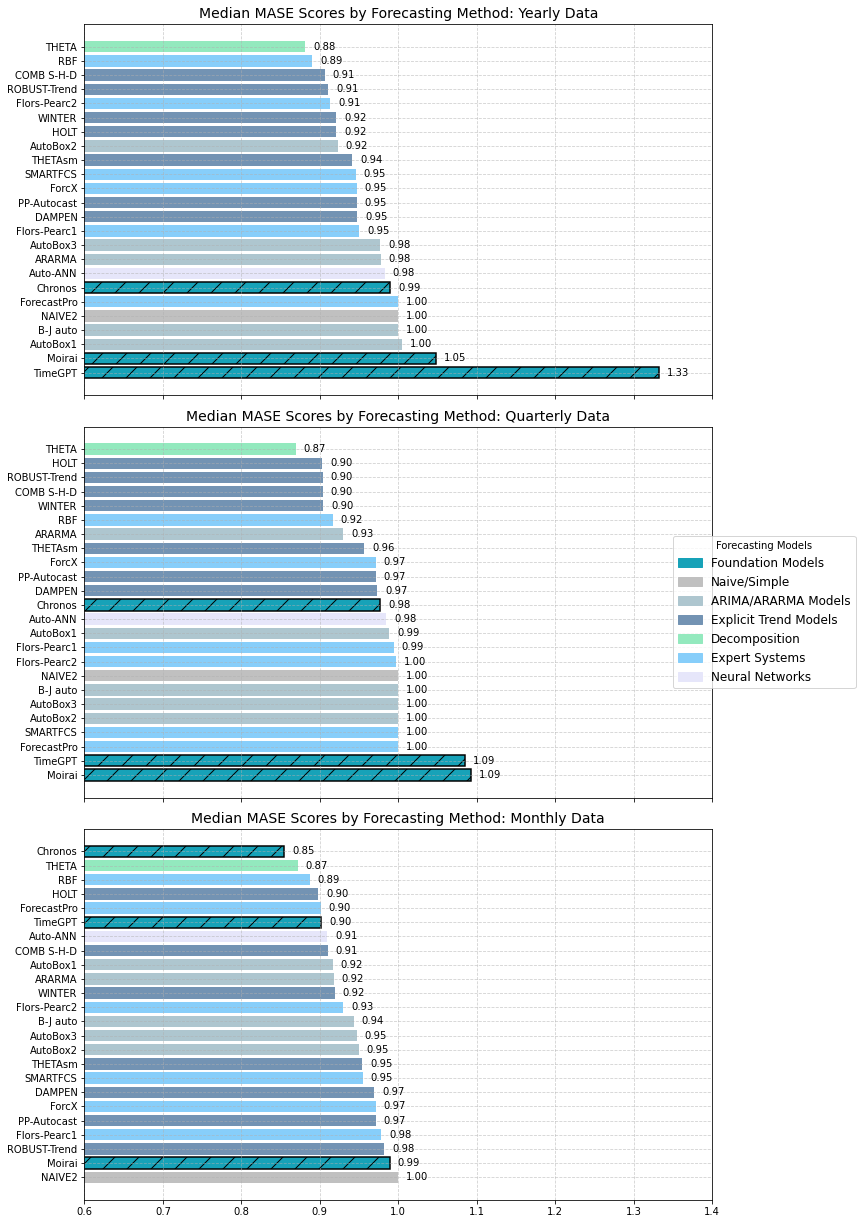

In [89]:

def plot_mase_results(mase_results, categories_dict, color_map, title="Median MASE Scores by Forecasting Method"):
    mase_df = pd.DataFrame.from_dict(mase_results, orient='index')

    median_mase = mase_df.median().sort_values()
    
    median_mase_df = pd.DataFrame(median_mase, columns=['MedianMASE'])
    median_mase_df = median_mase_df.reset_index()
    median_mase_df.columns = ['Method', 'MedianMASE']
    
    median_mase_df['Category'] = median_mase_df['Method'].map(categories_dict)
    category_colors = median_mase_df['Category'].map(color_map)
    
    plt.figure(figsize=(10, 8))
    bars = plt.barh(median_mase_df['Method'], median_mase_df['MedianMASE'], color=category_colors)
    
    transformer_bars = [bar for bar, method in zip(bars, median_mase_df['Method']) if 'Foundation Models' == median_mase_df.loc[median_mase_df['Method'] == method, 'Category'].values[0]]

    for bar in transformer_bars:
        bar.set_edgecolor('black')
        bar.set_linewidth(1.5)
        bar.set_hatch('/')
    
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.2f}', va='center', ha='left')
    
    plt.xlabel('Median MASE')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.legend(
        [plt.Rectangle((0,0),1,1, color=color_map[category]) for category in color_map],
        color_map.keys(),
        title="Forecasting Models",
        loc='best'
    )
    #plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(left=0.6)
    plt.tight_layout(rect=[0,0,0.85,1])
    plt.show()


def plot_combined_mase_results(yearly_results, quart_results, month_results, categories_dict, color_map):
    fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

    def plot_single_mase(ax, mase_results, title):
        mase_df = pd.DataFrame.from_dict(mase_results, orient='index')
        median_mase = mase_df.median().sort_values()
        median_mase_df = pd.DataFrame(median_mase, columns=['MedianMASE']).reset_index()
        median_mase_df.columns = ['Method', 'MedianMASE']
        median_mase_df['Category'] = median_mase_df['Method'].map(categories_dict)
        category_colors = median_mase_df['Category'].map(color_map)

        bars = ax.barh(median_mase_df['Method'], median_mase_df['MedianMASE'], color=category_colors)
        transformer_bars = [bar for bar, method in zip(bars, median_mase_df['Method']) if 'Foundation Models' == median_mase_df.loc[median_mase_df['Method'] == method, 'Category'].values[0]]

        for bar in transformer_bars:
            bar.set_edgecolor('black')
            bar.set_linewidth(1.5)
            bar.set_hatch('/')

        for bar in bars:
            ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.2f}', va='center', ha='left', fontsize=10)

        ax.set_title(title, fontsize=14)
        ax.invert_yaxis()
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_xlim(left=0.6, right=1.4)
        ax.tick_params(axis='both', which='major', labelsize=10)

    plot_single_mase(axes[0], yearly_results, "Median MASE Scores by Forecasting Method: Yearly Data")
    plot_single_mase(axes[1], quart_results, "Median MASE Scores by Forecasting Method: Quarterly Data")
    plot_single_mase(axes[2], month_results, "Median MASE Scores by Forecasting Method: Monthly Data")

    handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[category]) for category in color_map]
    labels = list(color_map.keys())
    fig.legend(handles, labels, title="Forecasting Models", loc='center right', fontsize=12)
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])
    plt.show()

plot_combined_mase_results(yearly_mase_results, quart_mase_results, month_mase_results, categories_dict, color_map)


# Calculate Median and Mean MASE Scores for each Category

In [90]:
# Convert each dictionary to a DataFrame and assign a category
df1 = pd.DataFrame.from_dict(micro_mase_results, orient='index')
df1['Category'] = 'MICRO'

df2 = pd.DataFrame.from_dict(industry_mase_results, orient='index')
df2['Category'] = 'INDUSTRY'

df3 = pd.DataFrame.from_dict(macro_mase_results, orient='index')
df3['Category'] = 'MACRO'

df4 = pd.DataFrame.from_dict(finance_mase_results, orient='index')
df4['Category'] = 'FINANCE'

df5 = pd.DataFrame.from_dict(demographic_mase_results, orient='index')
df5['Category'] = 'DEMOGRAPHIC'

df6 = pd.DataFrame.from_dict(other_mase_results, orient='index')
df6['Category'] = 'OTHER'

var_methods = [
            'THETA',
            'ForecastPro',
            'ForcX',
            'COMB S-H-D',
            'DAMPEN',
            'RBF',
            'TimeGPT',
            'Chronos',
            'Moirai'
]


# Concatenate all DataFrames
full_df = pd.concat([df1, df2, df3, df4, df5, df6])



# Calculate the median and mean for each model by category and round to 2 decimal places
statistics_df = full_df.groupby('Category').agg(['median', 'mean']).round(2)

# Optionally, you can rename the columns for better readability
statistics_df.columns = ['_'.join(col).strip() for col in statistics_df.columns.values]

# Display the statistics DataFrame
display(statistics_df)

,TimeGPT_median,TimeGPT_mean,Chronos_median,Chronos_mean,Moirai_median,Moirai_mean,ARARMA_median,ARARMA_mean,Auto-ANN_median,Auto-ANN_mean,...,ROBUST-Trend_median,ROBUST-Trend_mean,SMARTFCS_median,SMARTFCS_mean,THETA_median,THETA_mean,THETAsm_median,THETAsm_mean,WINTER_median,WINTER_mean
Category,,,,,,,,,,,,,,,,,,,,,
DEMOGRAPHIC,1.11,1.74,0.92,1.14,1.13,1.59,0.93,1.35,0.98,1.31,...,0.92,1.16,1.00,1.27,0.87,1.15,0.90,1.01,0.95,1.49
FINANCE,0.97,1.05,0.98,1.05,1.02,1.17,0.95,1.28,0.98,1.18,...,0.98,1.12,1.00,1.26,0.91,1.05,0.99,1.06,0.95,1.15
INDUSTRY,0.99,1.16,0.97,1.05,1.13,1.39,1.01,1.16,1.02,1.21,...,1.00,1.11,1.00,1.20,0.95,1.02,0.98,1.04,0.99,1.15
MACRO,1.02,1.25,0.86,1.10,1.02,1.24,0.76,1.15,0.92,1.17,...,0.70,1.09,0.99,1.25,0.82,0.96,0.95,0.99,0.78,1.23
MICRO,0.97,1.09,0.88,0.96,0.98,1.10,0.99,1.39,0.90,1.03,...,1.04,1.24,0.89,1.09,0.85,1.02,0.95,0.98,0.92,1.31
OTHER,0.85,0.87,0.88,0.85,0.88,0.99,0.72,0.77,0.89,1.50,...,0.86,1.45,0.87,0.95,0.84,0.76,0.94,0.91,0.86,0.94


# Create Table for Time Frequencies and Categories

In [91]:
data_dict = {
    'MICRO': micro_mase_results,
    'DEMOGRAPHIC': demographic_mase_results,
    'FINANCE': finance_mase_results,
    'INDUSTRY': industry_mase_results,
    'MACRO': macro_mase_results,
    'OTHER': other_mase_results
}


other_columns = ['Category']


var_methods = [
            'Chronos',
            'TimeGPT',
            'Moirai'
]

selected_columns = var_methods + other_columns


res_df = pd.DataFrame()

for category, mase_results in data_dict.items():
    temp_mase_results_df = pd.DataFrame.from_dict(mase_results, orient='index')
    temp_mase_results_df['Category'] = category
    res_df = pd.concat([res_df, temp_mase_results_df])

res_df = res_df[selected_columns]

res_df=res_df.sort_index(ascending=True)

horizon = np.where(res_df.index <= 646, 'YEARLY',
                   np.where(res_df.index <= 1402, 'QUART', 'MONTH'))

res_df['Horizon'] = horizon

statistics_df = res_df.groupby(['Horizon', 'Category']).agg(['median', 'mean']).round(2)

statistics_df.to_csv('statistics.csv')


display(statistics_df)


Chronos       TimeGPT       Moirai      
                     median  mean  median  mean median  mean
Horizon Category                                            
MONTH   DEMOGRAPHIC    0.87  1.16    0.95  0.97   1.11  1.21
        FINANCE        0.86  0.92    0.87  0.85   0.98  1.07
        INDUSTRY       0.98  1.05    0.93  1.01   1.11  1.19
        MACRO          0.79  0.98    0.91  0.98   1.03  1.18
        MICRO          0.79  0.82    0.88  0.88   0.92  0.93
        OTHER          0.80  0.84    0.83  0.85   0.88  1.02
QUART   DEMOGRAPHIC    1.06  1.11    0.99  1.26   1.05  1.41
        FINANCE        1.02  1.12    1.01  1.21   1.05  1.10
        INDUSTRY       0.96  1.06    1.13  1.45   1.28  1.56
        MACRO          0.95  1.25    1.11  1.36   1.04  1.33
        MICRO          0.97  1.09    1.09  1.31   1.15  1.38
YEARLY  DEMOGRAPHIC    0.93  1.14    1.51  2.20   1.18  1.80
        FINANCE        1.06  1.28    1.13  1.32   1.06  1.49
        INDUSTRY       0.95  1.08    1.15  1.43   1.10  1.87
        MACRO          1.02  0.95    1.73  1.84   0.95  1.07
        MICRO          1.01  1.20    1.29  1.45   1.04  1.27
        OTHER          0.99  0.93    0.99  0.98   0.89  0.87

# Calculate Percentage Better

In [92]:
def calculate_percentage_better(group):
    results = {
        'Chronos_Below_1': (group['Chronos'] < 1).mean(),
        'TimeGPT_Below_1': (group['TimeGPT'] < 1).mean(),
        'Moirai_Below_1': (group['Moirai'] < 1).mean(),
        'Count': group['Chronos'].count()  
    }
    return pd.Series(results)


percentage_better = res_df.groupby(['Horizon', 'Category']).apply(calculate_percentage_better)


percentage_better[['Chronos_Below_1', 'TimeGPT_Below_1', 'Moirai_Below_1']] = (percentage_better[['Chronos_Below_1', 'TimeGPT_Below_1', 'Moirai_Below_1']] * 100).round(2)


percentage_better.to_csv('percentage_better.csv')


percentage_better

Chronos_Below_1  TimeGPT_Below_1  Moirai_Below_1  Count
Horizon Category                                                            
MONTH   DEMOGRAPHIC            57.66            61.26           44.14  111.0
        FINANCE                62.07            63.45           53.79  145.0
        INDUSTRY               53.59            59.88           40.72  334.0
        MACRO                  69.55            64.42           46.79  312.0
        MICRO                  75.48            69.13           63.21  473.0
        OTHER                  67.31            67.31           57.69   52.0
QUART   DEMOGRAPHIC            45.61            50.88           45.61   57.0
        FINANCE                46.05            48.68           43.42   76.0
        INDUSTRY               55.42            38.55           26.51   83.0
        MACRO                  53.57            41.96           46.43  336.0
        MICRO                  53.92            39.71           34.80  204.0
YEARLY  DEMOGRAPHIC            55.51            31.84           39.18  245.0
        FINANCE                37.93            34.48           41.38   58.0
        INDUSTRY               57.84            34.31           43.14  102.0
        MACRO                  46.99             7.23           60.24   83.0
        MICRO                  46.26            26.53           46.94  147.0
        OTHER                  63.64            54.55           90.91   11.0

# Plot Median Scores by Category

In [93]:
res_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2829 entries, 1 to 2829
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Chronos   2829 non-null   float64
 1   TimeGPT   2829 non-null   float64
 2   Moirai    2829 non-null   float64
 3   Category  2829 non-null   object 
 4   Horizon   2829 non-null   object 
dtypes: float64(3), object(2)
memory usage: 132.6+ KB


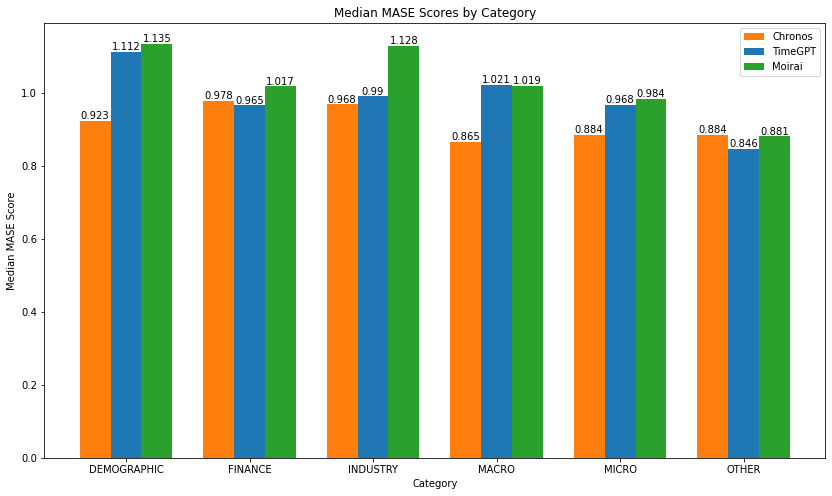

In [94]:
# Group the DataFrame by 'Category'
grouped = res_df.groupby('Category')

# Define a function to compute the median using np.median for numeric columns
def compute_group_median(group):
    return group[['Chronos', 'TimeGPT', 'Moirai']].apply(np.median)

# Apply the function to each group and reset the index
median_scores = grouped.apply(compute_group_median).reset_index()

# Extract the necessary columns for plotting
categories = median_scores['Category']
chronos_median = median_scores['Chronos']
timegpt_median = median_scores['TimeGPT']
moirai_median = median_scores['Moirai']

x = range(len(categories))

plt.figure(figsize=(14, 8))

bars1 = plt.bar(x, chronos_median, width=0.25, label='Chronos', color='tab:orange', align='center')
bars2 = plt.bar([p + 0.25 for p in x], timegpt_median, width=0.25, label='TimeGPT', color='tab:blue', align='center')
bars3 = plt.bar([p + 0.5 for p in x], moirai_median, width=0.25, label='Moirai', color='tab:green', align='center')

# Adding data labels
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 3), va='bottom', ha='center') 

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 3), va='bottom', ha='center')

for bar in bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 3), va='bottom', ha='center')

plt.xlabel('Category')
plt.ylabel('Median MASE Score')
plt.title('Median MASE Scores by Category')
plt.xticks([p + 0.25 for p in x], categories)
plt.legend()

plt.show()


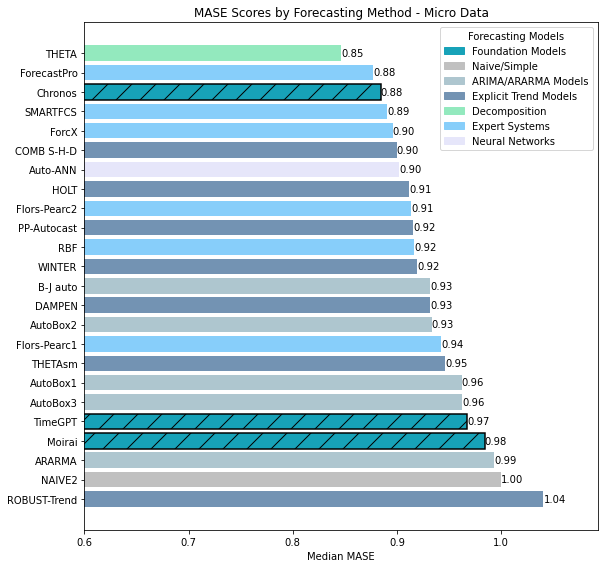

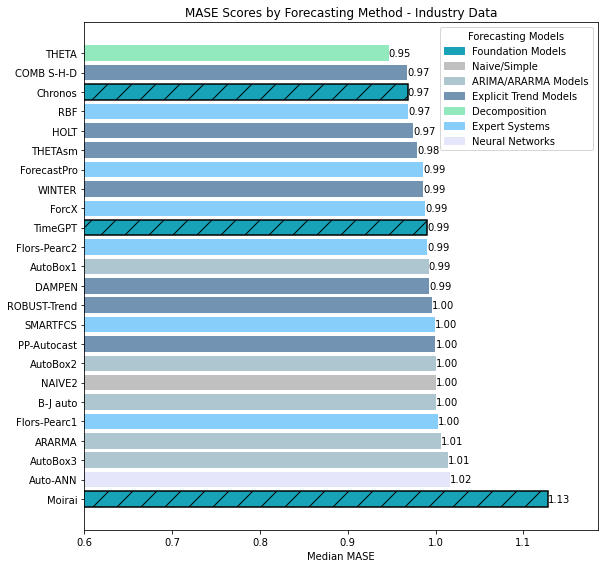

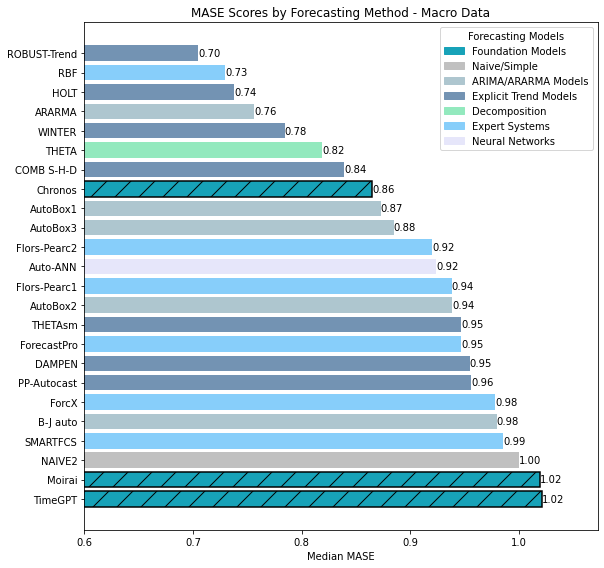

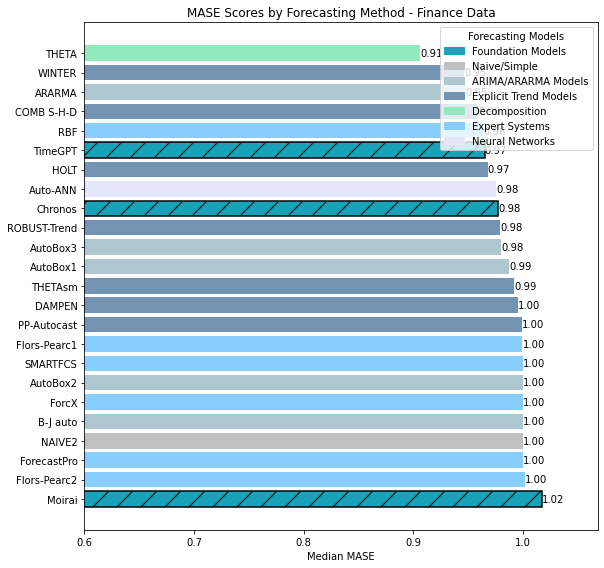

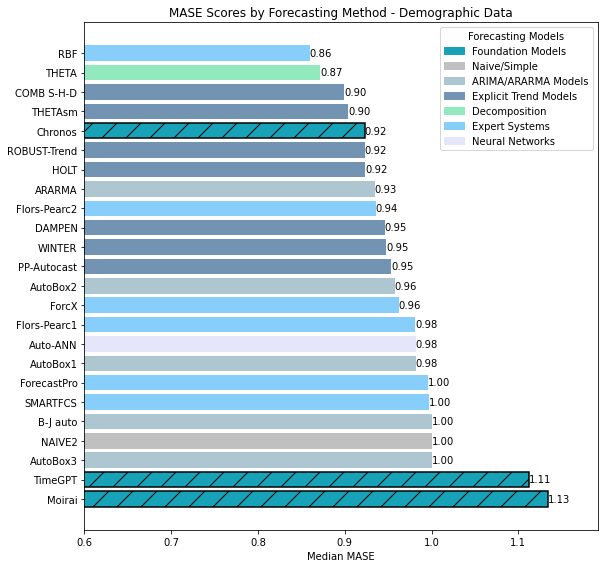

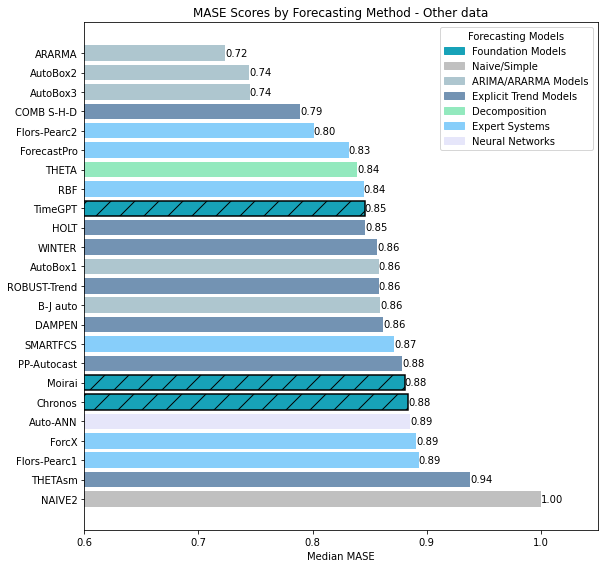

In [95]:
plot_mase_results(micro_mase_results, categories_dict, color_map, "MASE Scores by Forecasting Method - Micro Data")
plot_mase_results(industry_mase_results, categories_dict, color_map, "MASE Scores by Forecasting Method - Industry Data")
plot_mase_results(macro_mase_results, categories_dict, color_map, "MASE Scores by Forecasting Method - Macro Data")
plot_mase_results(finance_mase_results, categories_dict, color_map, "MASE Scores by Forecasting Method - Finance Data")
plot_mase_results(demographic_mase_results, categories_dict, color_map, "MASE Scores by Forecasting Method - Demographic Data")
plot_mase_results(other_mase_results, categories_dict, color_map, "MASE Scores by Forecasting Method - Other data")


# Tests of Results

This section outlines the statistical tests of our findings

## A Look at Distribution

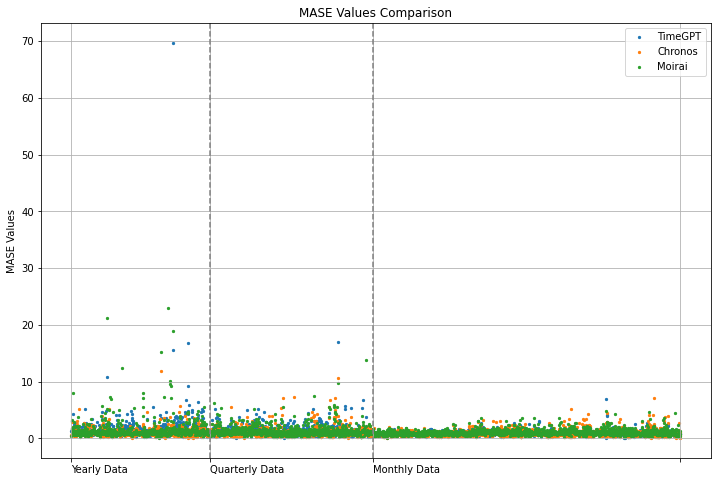

In [96]:

timegpt_mase = mase_df['TimeGPT'].sort_index()
chronos_mase = mase_df['Chronos'].sort_index()
moirai_mase = mase_df['Moirai'].sort_index()
theta_mase = mase_df['THETA'].sort_index()
benchmark_mase = mase_df['NAIVE2'].sort_index()
forecastpro_mase = mase_df['ForecastPro'].sort_index()
forcx_mase = mase_df['ForcX'].sort_index()
dampen_mase = mase_df['DAMPEN'].sort_index()
combshd_mase = mase_df['COMB S-H-D'].sort_index()
rbf_mase = mase_df['RBF'].sort_index()


plt.figure(figsize=(12, 8))

yearly_range = range(0, 646)
quarterly_range = range(646, 1402)
monthly_range = range(1402, 2830)

plt.scatter(timegpt_mase.index, timegpt_mase.values, label='TimeGPT', s=5)
plt.scatter(chronos_mase.index, chronos_mase.values, label='Chronos', s=5)
plt.scatter(moirai_mase.index, moirai_mase.values, label='Moirai', s=5)


plt.axvline(x=timegpt_mase.index[645], color='grey', linestyle='--')
plt.axvline(x=timegpt_mase.index[1401], color='grey', linestyle='--')

plt.xticks(
    ticks=[timegpt_mase.index[0], timegpt_mase.index[645], timegpt_mase.index[1401], timegpt_mase.index[-1]],
    labels=['Yearly Data', 'Quarterly Data', 'Monthly Data', ''],
    rotation=0,
    ha='left'
)

plt.ylabel('MASE Values')
plt.title('MASE Values Comparison')
plt.legend()
plt.grid(True)
plt.show()


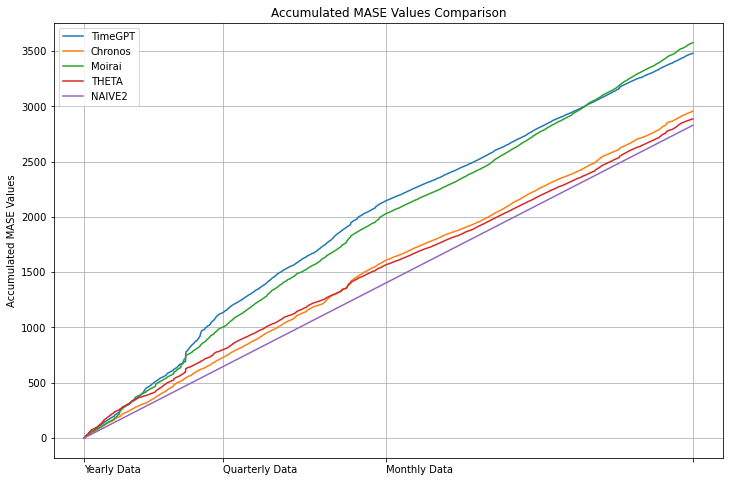

In [97]:
accumulated_timegpt_mase = timegpt_mase.cumsum()
accumulated_chronos_mase = chronos_mase.cumsum()
accumulated_moirai_mase = moirai_mase.cumsum()
accumulated_theta_mase = theta_mase.cumsum()
accumulated_benchmark_mase = benchmark_mase.cumsum()

plt.figure(figsize=(12, 8))

plt.plot(accumulated_timegpt_mase.index, accumulated_timegpt_mase.values, label='TimeGPT')
plt.plot(accumulated_chronos_mase.index, accumulated_chronos_mase.values, label='Chronos')
plt.plot(accumulated_moirai_mase.index, accumulated_moirai_mase.values, label='Moirai')
plt.plot(accumulated_theta_mase.index, accumulated_theta_mase.values, label='THETA')
plt.plot(accumulated_benchmark_mase.index, accumulated_benchmark_mase.values, label='NAIVE2')

plt.xticks(
    ticks=[timegpt_mase.index[0], timegpt_mase.index[645], timegpt_mase.index[1401], timegpt_mase.index[-1]],
    labels=['Yearly Data', 'Quarterly Data', 'Monthly Data', ''],
    rotation=0,
    ha='left'
)
plt.ylabel('Accumulated MASE Values')
plt.title('Accumulated MASE Values Comparison')
plt.legend()
plt.grid(True)
plt.show()

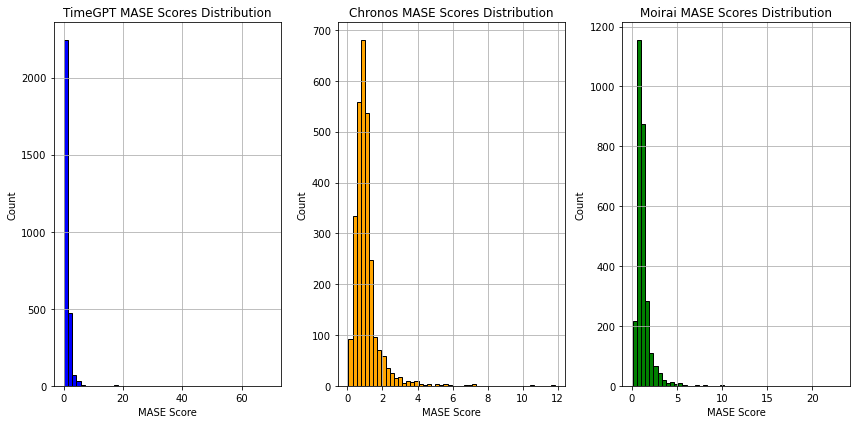

In [98]:
# Plotting the histograms
plt.figure(figsize=(12, 6))

# TimeGPT
plt.subplot(1, 3, 1)
plt.hist(timegpt_mase, bins=50, color='blue', edgecolor='black')
plt.title('TimeGPT MASE Scores Distribution')
plt.xlabel('MASE Score')
plt.ylabel('Count')
plt.grid(True)

# Chronos
plt.subplot(1, 3, 2)
plt.hist(chronos_mase, bins=50, color='orange', edgecolor='black')
plt.title('Chronos MASE Scores Distribution')
plt.xlabel('MASE Score')
plt.ylabel('Count')
plt.grid(True)

# Moirai
plt.subplot(1, 3, 3)
plt.hist(moirai_mase, bins=50, color='green', edgecolor='black')
plt.title('Moirai MASE Scores Distribution')
plt.xlabel('MASE Score')
plt.ylabel('Count')
plt.grid(True)

plt.tight_layout()
plt.show()

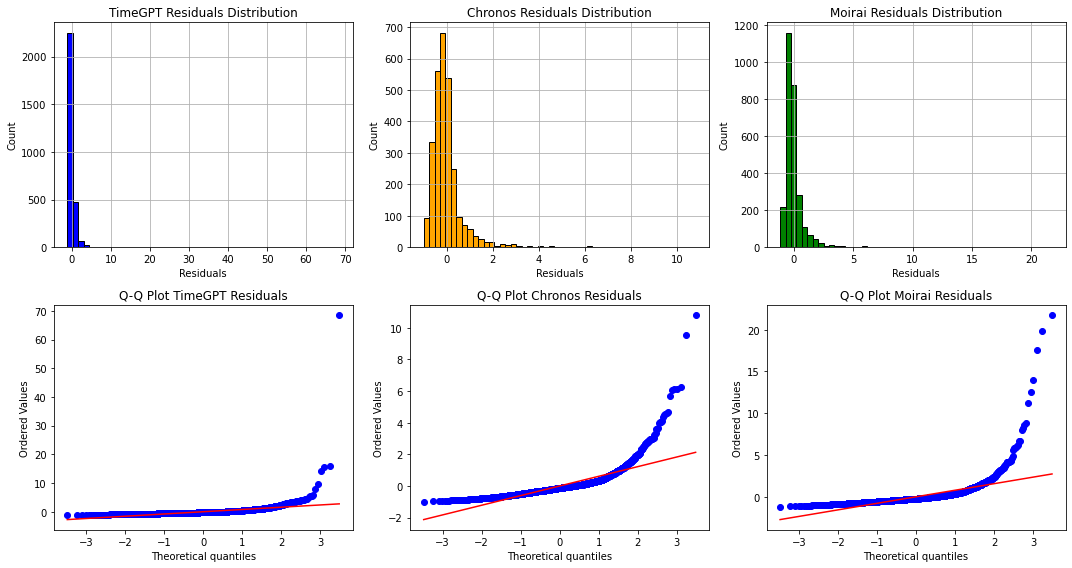

In [99]:
import scipy.stats as stats
# Calculate residuals
timegpt_residuals = mase_df['TimeGPT'] - mase_df['TimeGPT'].mean()
chronos_residuals = mase_df['Chronos'] - mase_df['Chronos'].mean()
moirai_residuals = mase_df['Moirai'] - mase_df['Moirai'].mean()

# Plotting the histograms
plt.figure(figsize=(15, 8))

# TimeGPT Histogram
plt.subplot(2, 3, 1)
plt.hist(timegpt_residuals, bins=50, color='blue', edgecolor='black')
plt.title('TimeGPT Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.grid(True)

# Chronos Histogram
plt.subplot(2, 3, 2)
plt.hist(chronos_residuals, bins=50, color='orange', edgecolor='black')
plt.title('Chronos Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.grid(True)

# Moirai Histogram
plt.subplot(2, 3, 3)
plt.hist(moirai_residuals, bins=50, color='green', edgecolor='black')
plt.title('Moirai Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.grid(True)

# Q-Q plot for TimeGPT
plt.subplot(2, 3, 4)
stats.probplot(timegpt_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot TimeGPT Residuals')

# Q-Q plot for Chronos
plt.subplot(2, 3, 5)
stats.probplot(chronos_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot Chronos Residuals')

# Q-Q plot for Moirai
plt.subplot(2, 3, 6)
stats.probplot(moirai_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot Moirai Residuals')

plt.tight_layout()
plt.show()

## Friedman's Test

In [100]:
# Convert lists to numpy arrays
timegpt_mase_array = np.array(timegpt_mase)
chronos_mase_array = np.array(chronos_mase)
moirai_mase_array = np.array(moirai_mase)


# Perform the Friedman's Test
stat, p = friedmanchisquare(timegpt_mase_array, moirai_mase_array, chronos_mase_array)
print(f"Friedman's Test Statistic: {stat}, p-value: {p}")


alpha = 0.05

# Interpret Friedman's Test results
if p < alpha:
    print("Fail to reject the null hypothesis - There is a statistically significant difference between the models.")
else:
    print("Reject the null hypothesis - There is no statistically significant difference between the models.")

Friedman's Test Statistic: 247.96818663839076, p-value: 1.426896352175751e-54
Fail to reject the null hypothesis - There is a statistically significant difference between the models.


## Levene's Test

In [101]:
# Convert lists to numpy arrays
timegpt_mase_array = np.array(timegpt_mase)
chronos_mase_array = np.array(chronos_mase)
moirai_mase_array = np.array(moirai_mase)


# Test for homoscedasticity using Levene's test
stat, p = levene(timegpt_mase_array, chronos_mase_array, moirai_mase_array)
print(f"Levene's Test Statistic: {stat}, p-value: {p}")

# Interpret Levene's test results
alpha = 0.05
if p > alpha:
    print("Fail to reject the null hypothesis - variances are equal (homoscedasticity).")
else:
    print("Reject the null hypothesis - variances are not equal (heteroscedasticity).")



Levene's Test Statistic: 4.808090348578604, p-value: 0.008185691864333012
Reject the null hypothesis - variances are not equal (heteroscedasticity).


## Wilcoxon Signed-Rank Test

In [102]:
theta_mase_array = np.array(theta_mase)
benchmark_mase_array = np.array(benchmark_mase)

model_arrays = [("THETA", theta_mase_array),
                ("Benchmark", benchmark_mase_array),
                ("TimeGPT", timegpt_mase_array),
                ("Chronos", chronos_mase_array),
                ("Moirai", moirai_mase_array),
                ("ForcastPro", forecastpro_mase),
                ("ForcX", forcx_mase),
                ("Dampen", dampen_mase),
                ("COMB S-H-D", combshd_mase),
                ("RBF", rbf_mase)]


# Perform pairwise comparisons
for i in range(len(model_arrays)):
    for j in range(i + 1, len(model_arrays)):
        name1, model1 = model_arrays[i]
        name2, model2 = model_arrays[j]
        
        # Perform Wilcoxon signed-rank test
        stat, p = wilcoxon(model1, model2)
        print(f"Wilcoxon Test between {name1} and {name2}:")
        print(f"Test Statistic: {stat}, p-value: {p}")
        
        # Interpret the test results
        alpha = 0.05
        if p > alpha:
            print("ACCEPT")
            print("Fail to reject the null hypothesis - the median of the differences in the matched pairs is equal to 0")
        else:
            print("REJECT")
            print("Reject the null hypothesis - the median of the differences in the matched pairs is not equal to 0")
        print()

Wilcoxon Test between THETA and Benchmark:
Test Statistic: 1398662.0, p-value: 8.954064366117404e-44
REJECT
Reject the null hypothesis - the median of the differences in the matched pairs is not equal to 0

Wilcoxon Test between THETA and TimeGPT:
Test Statistic: 1368180.0, p-value: 3.947597848628565e-48
REJECT
Reject the null hypothesis - the median of the differences in the matched pairs is not equal to 0

Wilcoxon Test between THETA and Chronos:
Test Statistic: 1756062.0, p-value: 1.610511576802143e-08
REJECT
Reject the null hypothesis - the median of the differences in the matched pairs is not equal to 0

Wilcoxon Test between THETA and Moirai:
Test Statistic: 1070629.0, p-value: 7.789374777180476e-102
REJECT
Reject the null hypothesis - the median of the differences in the matched pairs is not equal to 0

Wilcoxon Test between THETA and ForcastPro:
Test Statistic: 1844085.0, p-value: 0.0002907162856679099
REJECT
Reject the null hypothesis - the median of the differences in the mat

In [103]:
# Rank the models for each time series (each row)
mase_df = mase_df.drop(columns='NAIVE2')

ranked_df = mase_df.rank(axis=1, method='min')

# Initialize a dictionary to store the counts of ranks for TimeGPT, Chronos, and Moirai
foundation_models_rank_counts = {'TimeGPT': {}, 'Chronos': {}, 'Moirai': {}}

# Iterate through each time series to count ranks for TimeGPT, Chronos, and Moirai
for model in foundation_models_rank_counts.keys():
    foundation_models_rank_counts[model] = ranked_df[model].value_counts().sort_index().to_dict()

# Convert the rank_counts dictionary to a DataFrame for better visualization
foundation_models_rank_counts_df = pd.DataFrame(foundation_models_rank_counts).fillna(0).astype(int)

foundation_models_rank_counts_df.index = foundation_models_rank_counts_df.index.astype(int)

foundation_models_rank_counts_df

,TimeGPT,Chronos,Moirai
1,168,181,77
2,114,155,77
3,117,119,60
4,106,121,73
5,120,110,70
6,109,124,84
7,108,127,90
8,98,102,95
9,85,120,88
10,83,141,90


<Figure size 864x576 with 0 Axes>

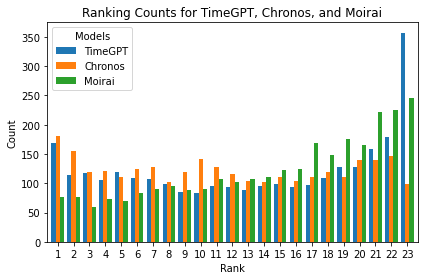

In [104]:
# Plotting the rank counts
plt.figure(figsize=(12, 8))
foundation_models_rank_counts_df.plot(kind='bar', width=0.8)

plt.title('Ranking Counts for TimeGPT, Chronos, and Moirai')
plt.xlabel('Rank')
plt.ylabel('Count')
plt.legend(title='Models')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

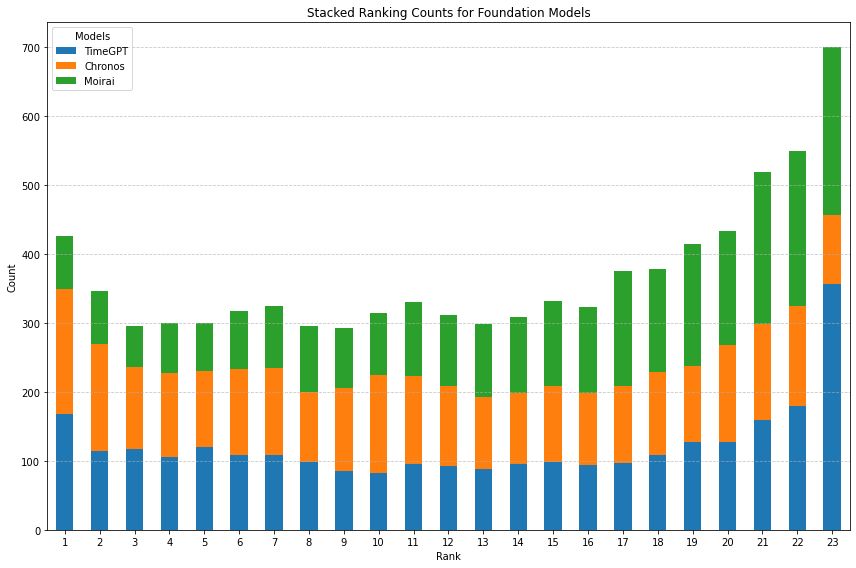

In [105]:
foundation_models_rank_counts_df.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title('Stacked Ranking Counts for Foundation Models')
plt.xlabel('Rank')
plt.ylabel('Count')
plt.legend(title='Models')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()


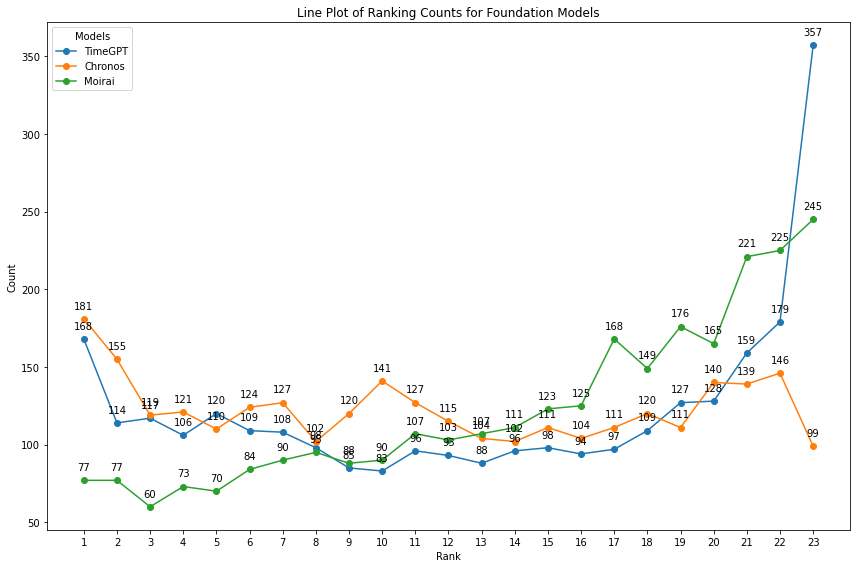

In [106]:

ax = foundation_models_rank_counts_df.plot(kind='line', marker='o', figsize=(12, 8))

# Add annotations for each point
for model in foundation_models_rank_counts_df.columns:
    for idx, value in enumerate(foundation_models_rank_counts_df[model]):
        ax.annotate(f'{value}', (foundation_models_rank_counts_df.index[idx], value), textcoords="offset points", xytext=(0,10), ha='center')

plt.xticks(ticks=foundation_models_rank_counts_df.index)

# Add titles and labels
plt.title('Line Plot of Ranking Counts for Foundation Models')
plt.xlabel('Rank')
plt.ylabel('Count')
plt.legend(title='Models')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


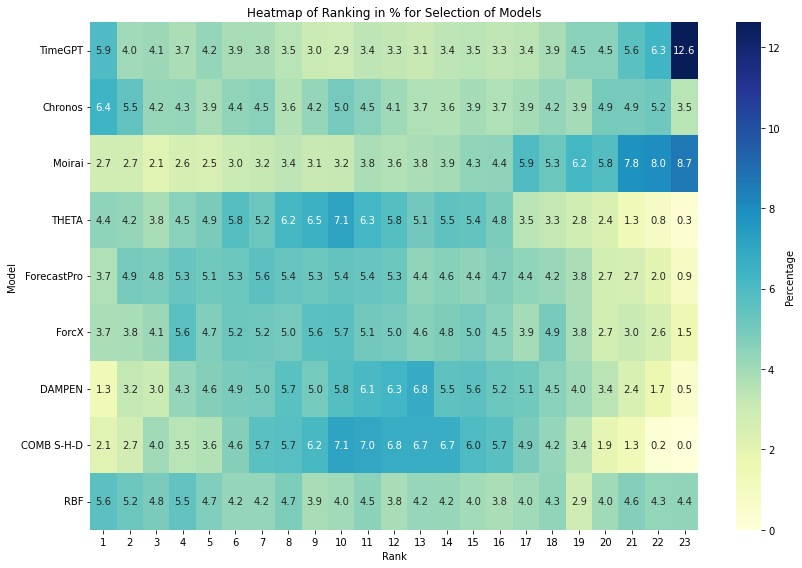

In [107]:
selection_models_rank_counts = {'TimeGPT': {}, 
                                 'Chronos': {}, 
                                 'Moirai': {},
                                 'THETA': {},
                                 'ForecastPro': {}, 
                                 'ForcX': {},
                                 'DAMPEN': {},
                                 'COMB S-H-D': {},
                                 'RBF': {}
                                 }

for model in selection_models_rank_counts.keys():
    selection_models_rank_counts[model] = ranked_df[model].value_counts().sort_index().to_dict()

# Convert the rank_counts dictionary to a DataFrame for better visualization
selection_models_rank_counts_df = pd.DataFrame(selection_models_rank_counts).fillna(0).astype(int)
selection_models_rank_counts_df.index = selection_models_rank_counts_df.index.astype(int)

percentages_df = selection_models_rank_counts_df.div(selection_models_rank_counts_df.sum(axis=0), axis=1) * 100

plt.figure(figsize=(12, 8))
sns.heatmap(percentages_df.T, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Percentage'})

plt.title('Heatmap of Ranking in % for Selection of Models')

plt.xlabel('Rank')
plt.ylabel('Model')

plt.tight_layout()
plt.show()


## Bootstrap Sampling for Robustness Check

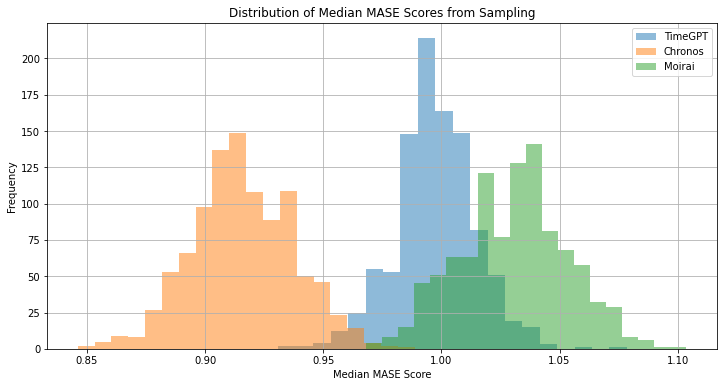

In [108]:
# Number of samples and sample size
n_samples = 1000
sample_size = 500 

def sampling_median_mase(df, n_samples, sample_size, model_names):
    results = {model: [] for model in model_names}
    
    for _ in range(n_samples):
        sample = df.sample(n=sample_size, replace=True)
        
        for model in model_names:
            median_mase = sample[model].median()
            results[model].append(median_mase)
    
    return results

# Perform sampling
model_names = ['TimeGPT', 'Chronos', 'Moirai']
sampling_results = sampling_median_mase(mase_df, n_samples, sample_size, model_names)

# Plot the results
plt.figure(figsize=(12, 6))

for model in model_names:
    plt.hist(sampling_results[model], bins=20, alpha=0.5, label=model)

plt.xlabel('Median MASE Score')
plt.ylabel('Frequency')
plt.title('Distribution of Median MASE Scores from Sampling')
plt.legend()
plt.grid(True)
plt.show()

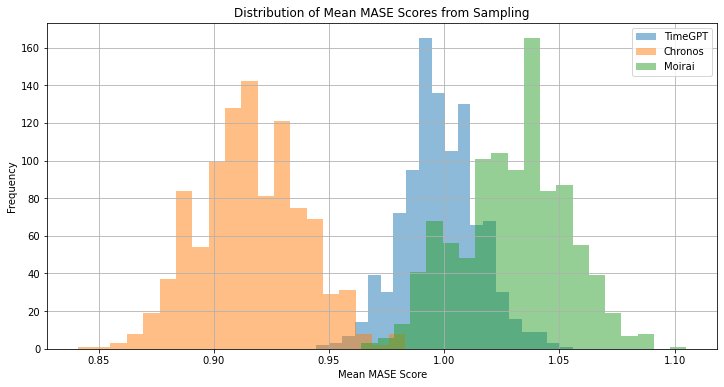

In [109]:
# Number of samples and sample size
n_samples = 1000
sample_size = 500 

# Function to perform sampling and compute mean MASE scores
def sampling_mean_mase(df, n_samples, sample_size, model_names):
    results = {model: [] for model in model_names}
    
    for _ in range(n_samples):
        sample = df.sample(n=sample_size, replace=True)
        
        for model in model_names:
            mean_mase = sample[model].mean()
            results[model].append(mean_mase)
    
    return results

# Perform sampling
model_names = ['TimeGPT', 'Chronos', 'Moirai']
sampling_results = sampling_median_mase(mase_df, n_samples, sample_size, model_names)

# Plot the results
plt.figure(figsize=(12, 6))

for model in model_names:
    plt.hist(sampling_results[model], bins=20, alpha=0.5, label=model)

plt.xlabel('Mean MASE Score')
plt.ylabel('Frequency')
plt.title('Distribution of Mean MASE Scores from Sampling')
plt.legend()
plt.grid(True)
plt.show()

### Chronos vs Selection

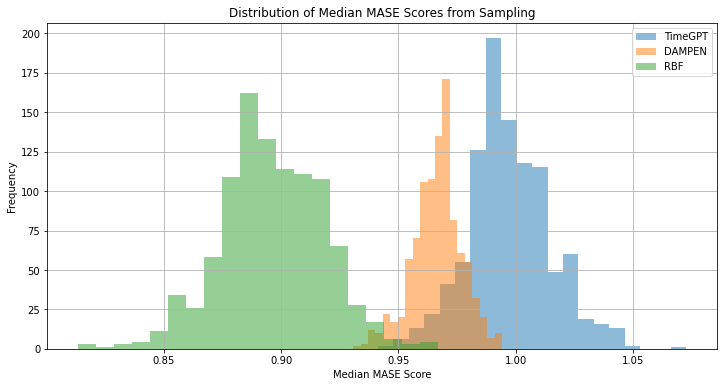

In [110]:
# Number of samples and sample size
n_samples = 1000
sample_size = 500 

# Function to perform sampling and compute median MASE scores
def sampling_median_mase(df, n_samples, sample_size, model_names):
    results = {model: [] for model in model_names}
    
    for _ in range(n_samples):
        sample = df.sample(n=sample_size, replace=True)
        
        for model in model_names:
            median_mase = sample[model].median()
            results[model].append(median_mase)
    
    return results

# Perform sampling
model_names = ['TimeGPT', 'DAMPEN', 'RBF']
sampling_results = sampling_median_mase(mase_df, n_samples, sample_size, model_names)

# Plot the results
plt.figure(figsize=(12, 6))

for model in model_names:
    plt.hist(sampling_results[model], bins=20, alpha=0.5, label=model)

plt.xlabel('Median MASE Score')
plt.ylabel('Frequency')
plt.title('Distribution of Median MASE Scores from Sampling')
plt.legend()
plt.grid(True)
plt.show()

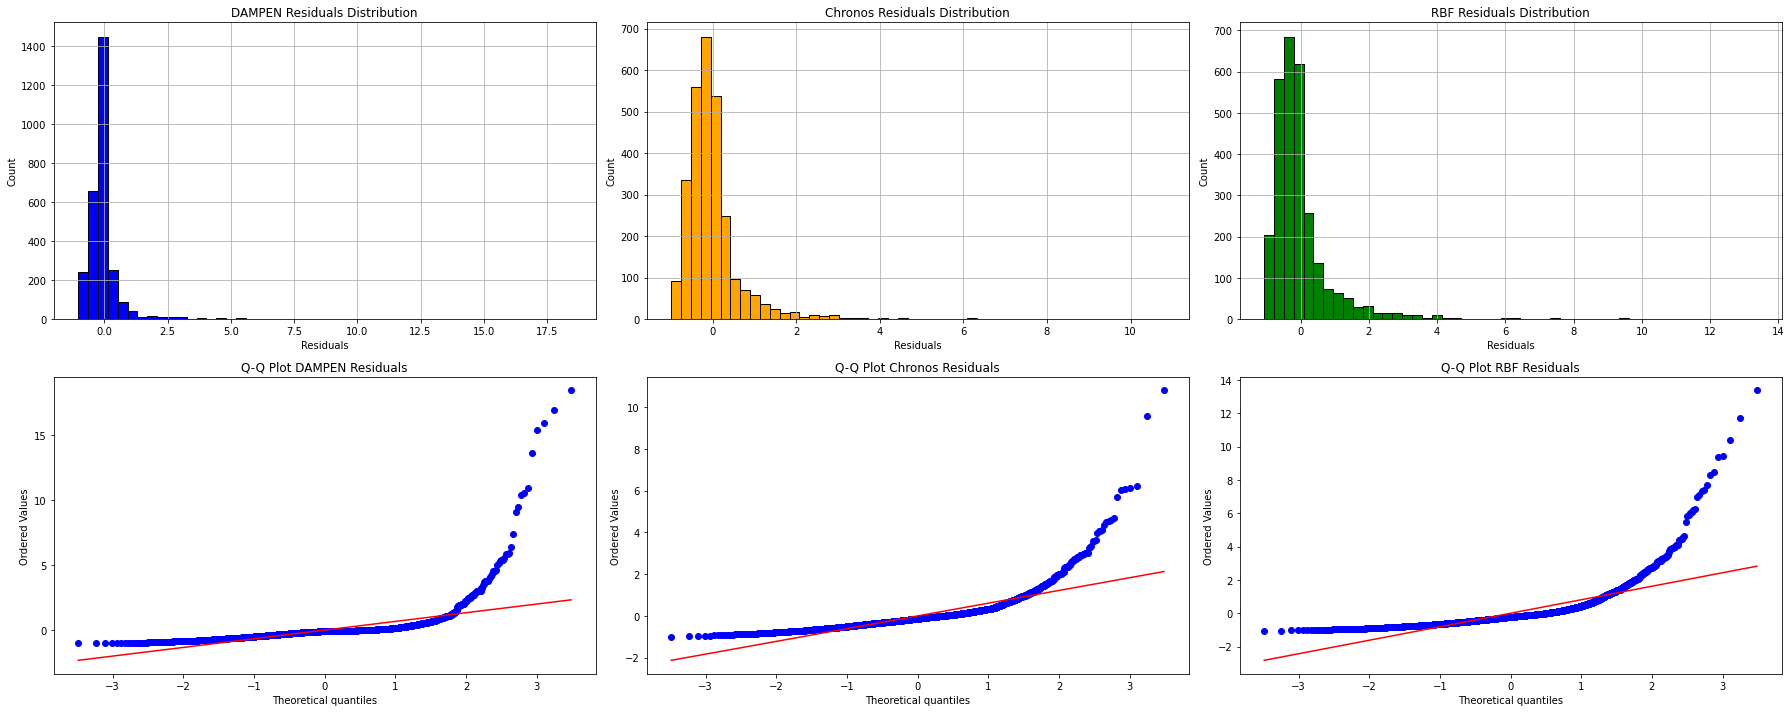

In [111]:
# Calculate residuals
dampen_residuals = mase_df['DAMPEN'] - mase_df['DAMPEN'].mean()
chronos_residuals = mase_df['Chronos'] - mase_df['Chronos'].mean()
rbf_residuals = mase_df['RBF'] - mase_df['RBF'].mean()

# Plotting the histograms
plt.figure(figsize=(25, 10))

# DAMPEN Histogram
plt.subplot(2, 3, 1)
plt.hist(dampen_residuals, bins=50, color='blue', edgecolor='black')
plt.title('DAMPEN Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.grid(True)

# Chronos Histogram
plt.subplot(2, 3, 2)
plt.hist(chronos_residuals, bins=50, color='orange', edgecolor='black')
plt.title('Chronos Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.grid(True)

# RBF Histogram
plt.subplot(2, 3, 3)
plt.hist(rbf_residuals, bins=50, color='green', edgecolor='black')
plt.title('RBF Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.grid(True)

# Q-Q plot for DAMPEN
plt.subplot(2, 3, 4)
stats.probplot(dampen_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot DAMPEN Residuals')

# Q-Q plot for Chronos
plt.subplot(2, 3, 5)
stats.probplot(chronos_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot Chronos Residuals')

# Q-Q plot for RBF
plt.subplot(2, 3, 6)
stats.probplot(rbf_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot RBF Residuals')

plt.tight_layout()
plt.show()